In [23]:
import numpy as np
import pandas as pd
from gensim.models import LdaModel
from helper_data import *
from helper_preprocess import *
from gensim.test.utils import datapath

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Chargement des données



In [2]:
# Load data
walks_folder = 'data/P5'
data = load_all_walks_tags(walks_folder, True)

In [3]:
mask = data['theme_id'].apply(lambda x: x.startswith('0:'))
data = data[mask]

In [4]:
run_ids = data['walk'].value_counts()
runs_lengths = run_ids[run_ids > 10]
data = data[data['walk'].isin(runs_lengths.index)]

In [5]:
data.shape

(948, 15)

In [6]:
data = data.replace('None', np.nan)

In [7]:
mapping = {v: k for k, v in enumerate(data['walk'].unique().tolist())}
data['walk'] = data['walk'].apply(lambda x: mapping[x])

In [8]:
# Drop the videos where nan occurs
data = data.dropna(subset='keywords')
tags = data['keywords'].tolist()
walks_id = data['walk'].tolist()

In [9]:
len(tags)

869

## Preprocessing

In [31]:
# Preprocess the data
tags_prep = [preprocess(t, tag=True) for t in tags]

['news']
['cbs', 'streaming', 'news', 'live']
['news', 'politics', 'decoded']
['conflict', 'ukraine', 'russia', 'explained', 'war']
['valery', 'man', 'injured', 'gerasimov', 'wounded', 'hand', 'aid', 'gen', 'russian', 'ukraine', 'putins', 'right', 'general', 'putin', 'donbas', 'health', 'war']
['spy', 'pakinsons', 'russia', 'western', 'disease', 'kgb', 'cancer', 'putin', 'hitler', 'victory', 'sanctions', 'parkinsons', 'surgery', 'day']
['ukraine', 'russia', 'guarantor', 'nuclear', 'azovstal', 'sanctions', 'shelling', 'russian', 'zelensky', 'western', 'hitler', 'attacks', 'war', 'downed', 'lavrov', 'plant', 'comparison', 'security', 'china', 'drones', 'donbas']
['arsenal', 'annihilation', 'hand', 'ukraine', 'russia', 'russian', 'nuclear', 'putin', 'explained', 'us', 'dead', 'war']
['air', 'russias', 'ilyshin', 'threat', 'features', 'ii', 'russia', 'su', 'nuclear', 'putin', 'fighter', 'specification', 'refuelling', 'ilyushin', 'parade', 'victory', 'war', 'day']
['ukraine', 'russia', 'pup

In [32]:
# Filter out words that appear in more than 30% of the videos and words that
# appear less than 3 times
min_words = 3
max_freq = 0.4

dictionary, corpus = create_corpus(tags_prep, min_words, max_freq)

In [33]:
len(corpus)

869

## Topics Modeling : LDA

In [40]:
# LDA parameters
workers = 3
passes = 1000
random_state = 123
num_topics = 15
alpha = 'auto' #0.05 # < 1 gives sparse topics distributions
eta = 'auto' #0.05 # < 1 gives sparse words distribution inside each topic

lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=passes, random_state=random_state, alpha=alpha, eta=eta)

# Save the model
tmp_file = datapath('lda_model')
lda_model.save(tmp_file)

# Load model
#lda_model = LdaModel.load(tmp_file)

In [41]:
lda_model.show_topics(formatted=False, num_topics=num_topics, num_words=10)

[(0,
  [('music', 0.03164965),
   ('audition', 0.027719256),
   ('australia', 0.026176753),
   ('australian', 0.024115993),
   ('show', 0.024011262),
   ('today', 0.023541575),
   ('news', 0.021865567),
   ('ally', 0.0207034),
   ('breakfast', 0.0207034),
   ('brown', 0.020703286)]),
 (1,
  [('city', 0.045175407),
   ('new', 0.035192218),
   ('growth', 0.027184958),
   ('world', 0.02569706),
   ('personal', 0.024186721),
   ('john', 0.024186544),
   ('theory', 0.021524236),
   ('town', 0.021188382),
   ('york', 0.021188382),
   ('crash', 0.018190088)]),
 (2,
  [('show', 0.04035333),
   ('daily', 0.037076235),
   ('tv', 0.034988668),
   ('noah', 0.034555748),
   ('trevor', 0.034555748),
   ('ireland', 0.034360908),
   ('episode', 0.03143322),
   ('northern', 0.028141484),
   ('irish', 0.02182143),
   ('royal', 0.021128265)]),
 (3,
  [('free', 0.07999696),
   ('camera', 0.075815),
   ('phone', 0.07358948),
   ('tonight', 0.029079422),
   ('news', 0.02900795),
   ('fox', 0.023929127),
   

In [64]:
# Interpret the topics
topics_name = ['Australian Music', 'New York', 'Daily Show', 'Fox News', 'World News', 'News', 'Talk Show', 'International Affairs', 'Ted Talk on Health', 'Ukraine-Russia', 'Sciences', 'Documentaries & History', 'Music', 'USA-North Korea', 'Rathee Dhruv']
topic_id2name = {i: topics_name[i] for i in range(num_topics)}
topic_name2id = {v: k for k, v in topic_id2name.items()}

## Visualisations des vidéos : t-SNE sur les distributions des topics

Nous utilisons le vecteur de la distribution des topics de chaque vidéo ainsi que l'algorithme t-SNE afin de les représenter en 2D.

In [44]:
# Build the "embeddings" for each document using its topics distribution
embeddings = np.zeros((len(corpus), num_topics))
for i, doc_bow in enumerate(corpus):
    topics_distr = lda_model.get_document_topics(doc_bow)
    embedding = [0.0] * num_topics

    for id, p in topics_distr:
        embedding[id] = p

    embeddings[i, :] = embedding

In [45]:
from sklearn.manifold import TSNE

# Init pca is more stable,
tsne = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=random_state)
corpus_emb = tsne.fit_transform(embeddings)

/home/cpittet/anaconda3/envs/shs/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Le topic le plus pertinent est attribué à chaque vidéo.

In [49]:
from matplotlib.colors import rgb2hex
import matplotlib.pyplot as plt

cmap = plt.get_cmap('magma')
def val2rgb(val):
    return rgb2hex(cmap(val)[:3])

xs, ys = corpus_emb[:, 0], corpus_emb[:, 1]
best_topic_ids = [np.argmax(row) for row in embeddings.tolist()]

# We will need to separate runs, here we have all runs of P3
colors = [val2rgb(i) for i in range(len(xs))]

In [50]:
# Use pandas and plotly instead
df = pd.DataFrame({'x': corpus_emb[:, 0], 'y': corpus_emb[:, 1], 'best_topic_id': best_topic_ids, 'walk_id': [str(i) for i in walks_id], 'color': colors})

In [52]:
import plotly.express as px

fig = px.scatter(df, x='x', y='y', color='walk_id', hover_data=['best_topic_id'], width=800, height=800, labels={'walk_id': 'Run'})
fig.update_layout(
    title='Projections des vidéos'
)
fig.show()

Ajout de ces nouvelles données au dataframe original.

In [222]:
df_embeddings = pd.DataFrame(embeddings, columns=[f'topic_id_{i}' for i in range(embeddings.shape[1])])
df_embeddings['video_best_topic_id'] = df_embeddings.apply(lambda row: np.argmax(row), axis=1)
df_embeddings['video_best_topic'] = df_embeddings['video_best_topic_id'].apply(lambda id: topic_id2name[id])
df_output = pd.concat([data.reset_index(drop=True), df_embeddings], axis=1)

In [223]:
# Only keep the first topic if there are multiple modes for a walk
df_walk_best_topic = df_output[['walk', 'video_best_topic_id']].groupby('walk').agg(lambda  x: pd.Series.mode(x)[0]).rename(columns={'video_best_topic_id': 'walk_best_topic_id'})
df_walk_best_topic['walk_best_topic'] = df_walk_best_topic['walk_best_topic_id'].apply(lambda id: topic_id2name[id])
df_output = df_output.join(df_walk_best_topic, on='walk', how='left')

### Nuages de mots des topics


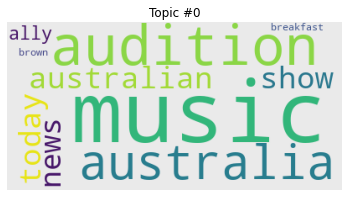

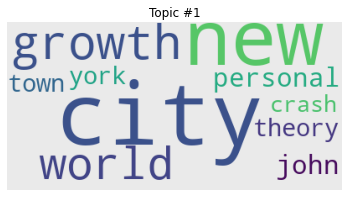

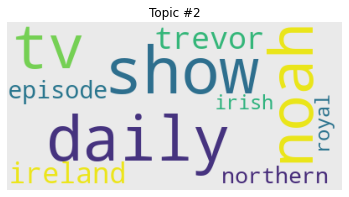

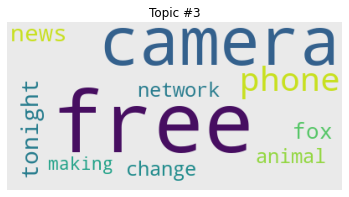

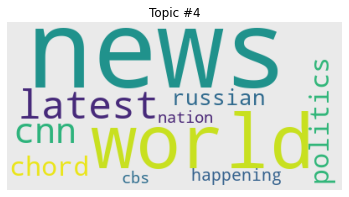

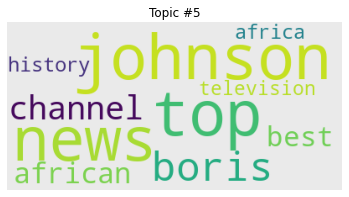

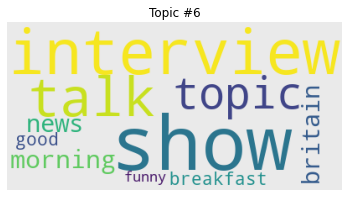

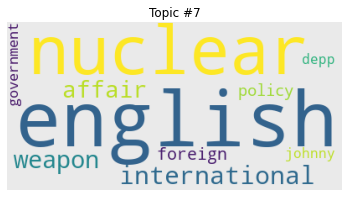

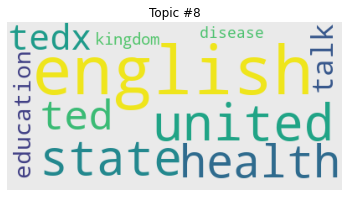

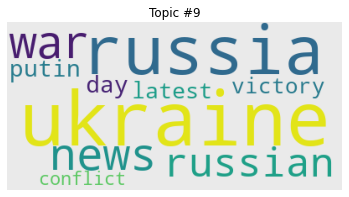

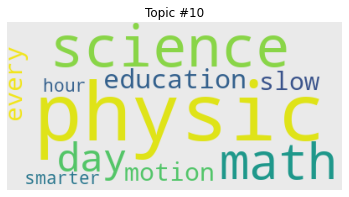

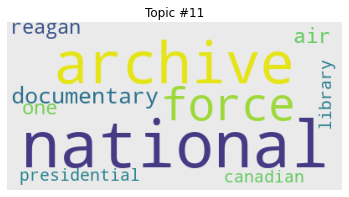

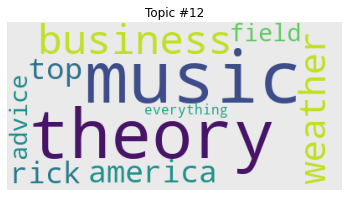

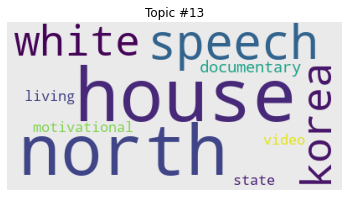

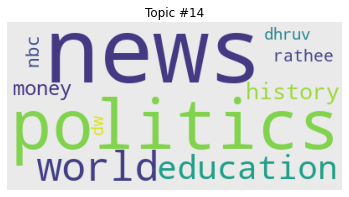

In [209]:
from wordcloud import WordCloud

for t in range(lda_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud(background_color='rgb(234, 234, 234)').fit_words(dict(lda_model.show_topic(t, 10))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.savefig(f'plots/word_cloud_topic_{t}.png')
    plt.show()

# Visualisations et statistiques de bases pour le site

In [224]:
df_output['x'] = corpus_emb[:, 0]
df_output['y'] = corpus_emb[:, 1]

In [225]:
all_topics = df_output['video_best_topic'].unique().tolist()

In [226]:
def str2color(txt):
    return rgb2hex(cmap(topic_name2id[str(txt)])[:3])

## Statistiques de base

### Durée des vidéos au fur et à mesure du run

In [227]:
df_output['walk'].value_counts().median()

17.5

In [231]:
def map_sub(x):
    tens = {'k': 1000, 'm': 1_000_000, 'b': 1_000_000_000}
    if x.isnumeric():
        return float(x)
    elif x[:-1].replace(',', '').replace('.', '').isnumeric() and x[-1].lower() in tens.keys():
        return float(x[:-1]) * tens[x[-1].lower()]
    else:
        return np.nan

df_plot = df_output.copy()

lst = []
for name, group in df_plot[['walk', 'video_id_in_run']].groupby('walk'):
    if 0 in group['video_id_in_run'].values:
        lst.append(group['walk'].values[0])

tmp = df_plot[df_plot['walk'].isin(lst)]
tmp = tmp[['theme_id', 'walk']].groupby('theme_id').nunique() == 3
tmp = tmp[tmp['walk']].index
df_out = df_plot[df_plot['theme_id'].isin(tmp)]
new_indexes = {j: i for i, j in enumerate(df_out['walk'].unique())}
df_out['walk'] = df_out['walk'].apply(lambda x: new_indexes[x])
df_out.loc[~df_out['nb_views'].isnull(), 'nb_views'] = df_out[~df_out['nb_views'].isnull()]['nb_views'].apply(lambda x: int(x.replace(',', '')))
df_out['nb_views'] = df_out['nb_views'].astype(float)

df_out.loc[~df_out['nb_sub'].isnull(), 'nb_sub'] = df_out[~df_out['nb_sub'].isnull()]['nb_sub'].apply(map_sub)
df_out['nb_sub'] = df_out['nb_sub'].astype(float)

279K
4.34M
274K
1.35M
1.35M
1.35M
1.35M
1.35M
1.35M
1.35M
9.44M
1.83M
1.83M
1.83M
1.8M
1.8M
1.84M
1.84M
1.08M
4.35M
9.02M
3.87M
969K
969K
11.9M
11.9M
11.9M
11.9M
11.9M
10.3M
2.12M
593K
226K
86.7K
219K
2.87M
13.8M
2.87M
2.87M
2.87M
2.87M
2.87M
4.86M
1.88M
1.62M
4.86M
588K
1.99M
813K
5.96M
6.72M
6.72M
3.12M
3.12M
1.03M
6.72M
2.45M
6.72M
73.1K
2.43M
13.8M
34.7M
34.7M
34.7M
34.7M
34.7M
34.7M
34.7M
34.7M
34.7M
34.7M
34.7M
34.7M
34.7M
34.7M
34.7M
3.12M
3.82M
103K
260K
221K
518K
3.02M
3.02M
2.1M
3.37M
34.7M
34.7M
34.7M
34.7M
34.7M
34.7M
34.7M
3.87M
1.04M
3.87M
2.05M
4.86M
1.04M
3.87M
3.07M
407K
4.86M
3.87M
1.43K
1.59M
1.59M
1.59M
13M
13M
1.6M
5.99M
5.99M
13.8M
12.3M
684K
215K
34.7M
34.7M
34.7M
34.7M
34.7M
34.7M
34.7M
34.7M
34.7M
34.7M
34.7M
34.7M
34.7M
3.47M
1.77M
291K
176K
176K
197K
125K
20.6K
3.45M
103K
1.06K
88.9K
368K
3.72M
237K
1.21M
1.39M
716K
5.4M
3.41M
45K
4.21M
112K
516K
4.04M
4.04M
7.42M
7.42M
2.28M
176K
393K
1.39M
26.2K
877K
877K
1.28K
141K
773K
74.5K
74.5K
26K
211K
50.3K
301K
1.08

/tmp/ipykernel_25489/3774270980.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_25489/3774270980.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_25489/3774270980.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [234]:
import plotly.graph_objects as go

fig = go.Figure()
i = 0

color_map = {id: i for i, id in enumerate(df_out['theme_id'].unique())}
for name, group in df_out.groupby('walk'):
    # select only the data for the current runs
    runs_of_interest = df_out[df_out['theme_id'] == group['theme_id'].values[0]].sort_values("walk")

    # Get mappins for walk_id to its view category
    walk_id = runs_of_interest[runs_of_interest['video_id_in_run']==0].sort_values("nb_views",ascending=True).walk.reset_index(drop=True)
    names = {walk_id[0]:"Moins de 5'000 vues", walk_id[1]:"Entre 5'000 et 50'000", walk_id[2]:"Plus que 50'000 vues"}

    customdata = []
    group.apply(lambda row: customdata.append([row['video_duration'], row['theme'], row['walk']]), axis=1)
    fig.add_trace(go.Scatter(
        x=group['video_id_in_run'],
        y=group['video_duration'],
        mode='lines+markers',
        marker={'color': px.colors.qualitative.Dark24[color_map[group['theme_id'].values[0]]]},
        customdata=customdata,
        hovertemplate='Durée [s]: %{customdata[0]:d}<br>Thème: %{customdata[1]}<br>Run: %{customdata[2]}',
        visible='legendonly' if i >= 6 else None,
        name=names[group['walk'].values[0]],
        legendgroup=group['theme_id'].values[0],
        legendgrouptitle_text=group['theme'].values[0]
    ))
    i += 1

fig.update_yaxes(type='log')
fig.update_layout(
    legend_title='Run',
    title='Durée des vidéos durant le run',
    xaxis_title='Position dans le run',
    yaxis_title='Durée [s]'
)
fig.write_html('plots/p5_video_duration.html')
fig.show()

### Nombre de vues durant le run

In [236]:
fig = go.Figure()
i = 0

color_map = {id: i for i, id in enumerate(df_out['theme_id'].unique())}
for name, group in df_out.groupby('walk'):
    # select only the data for the current runs
    runs_of_interest = df_out[df_out['theme_id'] == group['theme_id'].values[0]].sort_values("walk")

    # Get mappins for walk_id to its view category
    walk_id = runs_of_interest[runs_of_interest['video_id_in_run']==0].sort_values("nb_views",ascending=True).walk.reset_index(drop=True)
    names = {walk_id[0]:"Moins de 5'000 vues", walk_id[1]:"Entre 5'000 et 50'000", walk_id[2]:"Plus que 50'000 vues"}

    customdata = []
    group.apply(lambda row: customdata.append([row['nb_views'], row['theme'], row['walk']]), axis=1)
    fig.add_trace(go.Scatter(
        x=group['video_id_in_run'],
        y=group['nb_views'],
        mode='lines+markers',
        marker={'color': px.colors.qualitative.Dark24[color_map[group['theme_id'].values[0]]]},
        customdata=customdata,
        hovertemplate='Nbr. de vues: %{customdata[0]:d}<br>Thème: %{customdata[1]}<br>Run: %{customdata[2]}',
        visible='legendonly' if i >= 6 else None,
        name=names[group['walk'].values[0]],
        legendgroup=group['theme_id'].values[0],
        legendgrouptitle=dict(text=group['theme'].values[0])
    ))
    i += 1

fig.update_yaxes(type='log')
fig.update_layout(
    legend_title='Run',
    title='Nombre de vues des vidéos durant le run',
    xaxis_title='Position dans le run',
    yaxis_title='Nbr. de vues'
)
fig.write_html('plots/p5_nb_views.html')
fig.show()

### Nombre de followers des chaînes durant le run

In [235]:
fig = go.Figure()
i = 0

color_map = {id: i for i, id in enumerate(df_out['theme_id'].unique())}
for name, group in df_out.groupby('walk'):
    # select only the data for the current runs
    runs_of_interest = df_out[df_out['theme_id'] == group['theme_id'].values[0]].sort_values("walk")

    # Get mappins for walk_id to its view category
    walk_id = runs_of_interest[runs_of_interest['video_id_in_run']==0].sort_values("nb_views",ascending=True).walk.reset_index(drop=True)
    names = {walk_id[0]:"Moins de 5'000 vues", walk_id[1]:"Entre 5'000 et 50'000", walk_id[2]:"Plus que 50'000 vues"}

    customdata = []
    group.apply(lambda row: customdata.append([row['nb_sub'], row['theme'], row['walk']]), axis=1)
    fig.add_trace(go.Scatter(
        x=group['video_id_in_run'],
        y=group['nb_sub'],
        mode='lines+markers',
        marker={'color': px.colors.qualitative.Dark24[color_map[group['theme_id'].values[0]]]},
        customdata=customdata,
        hovertemplate='Nbr. de followers: %{customdata[0]:d}<br>Thème: %{customdata[1]}<br>Run: %{customdata[2]}',
        visible='legendonly' if i >= 6 else None,
        name=names[group['walk'].values[0]],
        legendgroup=group['theme_id'].values[0],
        legendgrouptitle=dict(text=group['theme'].values[0])
    ))
    i += 1

fig.update_yaxes(type='log')
fig.update_layout(
    legend_title='Run',
    title='Nombre de followers des chaînes durant le run',
    xaxis_title='Position dans le run',
    yaxis_title='Nbr. de followers'
)
fig.write_html('plots/p5_nb_sub.html')
fig.show()

### Histrogramme nombre de vidéos par topic

In [238]:
# Compute the histogram data
data_df = (df_out.loc[:,['keywords', 'video_best_topic_id']]
    .groupby('video_best_topic_id') # Group videos by their videos best_topic_id
    .count() # Perform the count needed for the histogram
    .reset_index()
    .rename(columns={"video_best_topic_id":"Topic", "keywords":"Count"})) # rename columns to more meaningful title

# Create plot
fig = px.bar(data_df, x='Topic',y="Count")
fig.update_layout(
    title="Nombre de vidéos par topic",
    xaxis_title="Nombre de topics",
    yaxis_title="Nombre de vidéos")
fig.write_html('plots/p5_hist_nb_vid_per_topic.html')
fig.show()

In [244]:
# Compute histogram data
data_df = (df_out.groupby(['video_id_in_run', 'video_best_topic_id']) # Group videos by their best topic and video position in run
.count() # count for histogram
.reset_index()
     .loc[:,["video_id_in_run", "video_best_topic_id","title"]] # Keep only needed columns
.rename(columns={"title":"Nombre de vidéo dans le topic", "video_best_topic_id":"Numéro de topic", "video_id_in_run":"Position de la vidéo dans la run"})) # Rename columns to have more meaningful name

# Set empty (video_id_in_run, video_best_topic_id) pairs to 0 to avoid issue when plotting
for i in range(data_df["Position de la vidéo dans la run"].max()+1):
    for j in range(12):
        cur = data_df[data_df["Position de la vidéo dans la run"]==i]
        cur = cur[cur["Numéro de topic"]==j]
        if len(cur)==0:
            # add a row with 0 count if the dataframe doesn't contain anything for the (video_id_in_run, video_best_topic_id) pair
            data_df=pd.concat([data_df, pd.DataFrame.from_dict({"Position de la vidéo dans la run":[i], "Numéro de topic":[j], "Nombre de vidéo dans le topic":[0]})])

In [247]:
# Get the maximal value
max_value = data_df["Nombre de vidéo dans le topic"].max()
# Plot animated histogram
fig = px.bar(data_df, x="Numéro de topic", y="Nombre de vidéo dans le topic", animation_frame="Position de la vidéo dans la run",  range_y=[0, max_value], range_x=[-0.5, 11.5])
# Set the time between frame to 1.1 sec
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1100
fig.update_xaxes(tick0=0)
fig.update_xaxes(dtick=1)
fig.update_layout(
    title="Nombre de vidéo par topic durant une run"
)
fig.write_html('plots/p5_nb_topic_in_video.html')
fig.show()

### Histogramme nombre de runs par topic

In [248]:

data_df = (df_out.loc[:,['keywords', 'walk_best_topic_id']] # Group videos by their walk best topic and video position in run
.groupby('walk_best_topic_id')
    .count() # count for histogram
.reset_index()
    .rename(columns={"walk_best_topic_id":"Topic", "keywords":"Count"}))# Rename columns to have more meaningful name

# Plot the histogram
fig = px.bar(data_df, x='Topic',y="Count")
fig.update_layout(
    title="Nombre de runs par topic",
    xaxis_title="Numéro de topic",
    yaxis_title="Nombre de runs classifié dans le topic ",
    xaxis=dict(
        tickmode = 'array',
        tickvals=np.arange(0, embeddings.shape[1]).astype(int),
    ))
fig.write_html('plots/p5_nb_run_per_topic.html')
fig.show()

### Navigation pour les runs partant des mêmes mots clés

In [269]:
def get_or_else(df, i, coor):
    if i in df["video_id_in_run"].values:
        return df[df["video_id_in_run"]==i][coor].values[0]
    else:
        return 0.0

def get_xs(df, i):
    """
    Get the next 3 X position in the dataframe
    :param df: the dataframe
    :param i: starting position
    :return: a list with the next 3 x position in the dataframe
    """
    return [get_or_else(df, j, "x") for j in range(i, i+3)]

def get_ys(df, i):
    """
    Get the next 3 y position in the dataframe
    :param df: the dataframe
    :param i: starting position
    :return: a list with the next 3 y position in the dataframe
    """
    return [get_or_else(df, j, "y") for j in range(i, i+3)]

In [274]:
import plotly.graph_objects as go

for idx, group in df_out.groupby('theme_id'):
    # select only the data for the current runs
    runs_of_interest = df_out[df_out['theme_id']==idx].sort_values("walk")

    # Get mappins for walk_id to its view category
    walk_id = runs_of_interest[runs_of_interest['video_id_in_run']==0].sort_values("nb_views",ascending=True).walk.reset_index(drop=True)
    names = {walk_id[0]:"Moins de 5'000 vues", walk_id[1]:"Entre 5'000 et 50'000", walk_id[2]:"Plus que 50'000 vues"}

    # Get the minimal number of videos in any of the walk for the current subject
    max_length = runs_of_interest.groupby('walk').max('video_id_in_run')['video_id_in_run'].min()

    # Start with empty data
    data = []
    frames = []

    # Define color for the plot
    colors = ["blue", "green", "orange"]

    # Create animation for the
    for i in range(max_length-2):
        # List that will store the current frame data
        cur_frame = []

        # Counter to know in which
        cpt=0
        for j, group2 in runs_of_interest.groupby('walk'):
            #
            cur_data = group2.sort_values("video_id_in_run").reset_index()
            # Collect hover data


            # Get the current considered point and the two nexts
            xs = get_xs(cur_data,i)
            ys = get_ys(cur_data,i)

            # Iterate over every run in the subject
            for k in range(len(names)):
                infos = []
                cur_data[cur_data.video_id_in_run==k].apply(lambda x: infos.append([names[x['walk']],x['title'], x['nb_views'],x['video_duration']]),axis=1)
                # plot the current 3 considered data points for the run
                cur_frame.append(go.Scatter(
                    x=[xs[k]],
                    y=[ys[k]],
                    marker = {'color' : colors[cpt], "opacity":(k+1)*1/3}, # set the opacity to 1/3 for the oldest points to 1 for the latest
                    mode='markers',
                    customdata=infos,
                    hoverinfo="none",# Disable run number information
                    hovertemplate='Run:%{customdata[0]}<br>Titre:%{customdata[1]}<br>Nombre de vues: %{customdata[2]}<br>Durée de la vidéo [s]: %{customdata[3]}<br>x:%{x:.3f}<br>y:%{y:.3f}',#Display custom information on hover
                    name=names[j],# Add name for the legend panel
                    showlegend=(k==(len(names)-1)), # Show the legend only for the latest point
                    legendgroup=colors[cpt]))

            # Draw line between the poitns cosnidered
            for k,l in [[0,1], [1,2]]:
                cur_frame.append(go.Scatter(
                    x=[xs[k], xs[l]],
                    y=[ys[k], ys[l]],
                    marker = {'color' : colors[cpt]},
                    mode='lines',
                    opacity=l*1/2,
                    hoverinfo="none",# Disable run number information
                    name=names[j],# Add name for the legend panel
                    showlegend=False,
                    legendgroup=colors[cpt]))

            cpt+=1
        if i==0:
            # Set other data to grey to put the run in context
            data = cur_frame+[go.Scatter(x=df_output['x'].values,
                                         y=df_output['y'].values,
                                         mode = 'markers',
                                         opacity=0.4,
                                         marker={"color":"grey"},
                                         showlegend=False,
                                         hoverinfo="skip",
                                         name="")]
        # Append the current frame to all the frames
        frames.append(go.Frame(data=cur_frame))

    # Create a animated scatter plot
    fig = go.Figure(
        data=data,
        layout=go.Layout(
            xaxis=dict(range=[-50, 50]),
            yaxis=dict(range=[-50, 50]),
            title="Evolution de la run pour le thème : "+runs_of_interest.theme.unique()[0],
            updatemenus=[dict(
                type="buttons",
                buttons=[dict(label="Play",
                              method="animate",
                              args = [None, {"frame": {"duration": 800,"redraw": False},
                                             "fromcurrent": True,
                                             "transition": {"duration": 300}}])])] # Set transition duration
        ),
        frames=frames
    )

    fig.update_layout(
        width=1000,
        height=800,
        legend_title_text='Catégorie (en fonction des vues) de la vidéo de départ '
    )
    fig.write_html(f'plots/p5_category_first_video_theme_{idx}.html')
    #fig.show()

In [277]:
names = {}
label = ["[0, 5000]", "]5'000,50'000]", ">50'000"]

for idx, group in df_out.groupby("theme_id"):
    cpt=0
    for idx2, row in group[group['video_id_in_run']==0].sort_values("nb_views",ascending=True).iterrows():
        names[row['walk']] = row["theme_id"] + " (" +label[cpt]+")"
        cpt+=1

df_plot = df_out.copy()
df_plot['id'] = df_out.apply(lambda x: names[x['walk']],axis=1)
df_plot = df_plot.rename(columns={"id":"Run", "video_id_in_run":"Position de la vidéo dans la run", "video_best_topic_id": "Meilleur topic pour la vidéo"})
df_plot = df_plot.pivot(index='Run', columns='Position de la vidéo dans la run', values='Meilleur topic pour la vidéo')
fig = px.imshow(df_plot)
fig.update_layout(
    height=700,
    coloraxis={"showscale":False}
)
fig.write_html('plots/p5_best_topic_per_video.html')
fig.show()